## Plain CNN
(note: I will import tenserflow Caltech101 dataset instead of torch, because I had issues with torch )

In [4]:
import tensorflow as tf
import tensorflow_datasets 
import numpy as np
from sklearn.metrics import *

data, info = tensorflow_datasets.load('caltech101', with_info=True, as_supervised=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling C:\Users\sindr\tensorflow_datasets\caltech101\3.0.2.incomplete7J2DXQ\caltech101-train.tfrecord*...: …

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling C:\Users\sindr\tensorflow_datasets\caltech101\3.0.2.incomplete7J2DXQ\caltech101-test.tfrecord*...:  …

Dataset caltech101 downloaded and prepared to C:\Users\sindr\tensorflow_datasets\caltech101\3.0.2. Subsequent calls will reuse this data.


In [17]:
class_names = info.features['label'].names
train, test = data['train'], data['test']

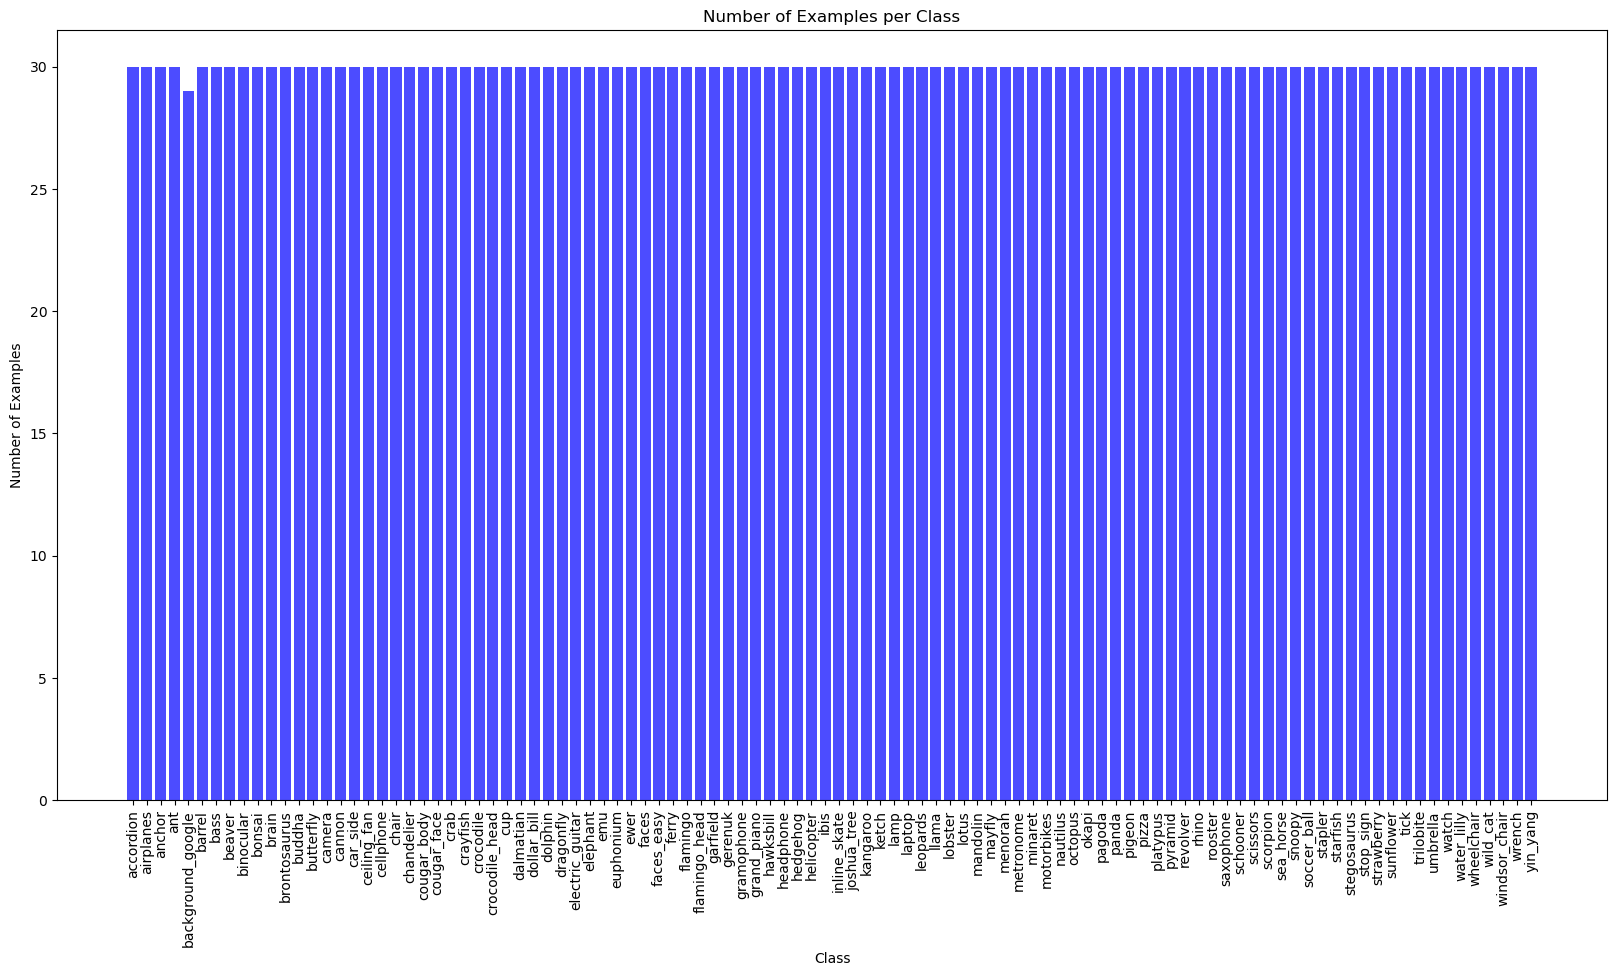

In [19]:
import matplotlib.pyplot as plt

class_items = {class_name: 0 for class_name in class_names}

for image, label in data['train']:
    class_name = class_names[label.numpy()]
    class_items[class_name] += 1

plt.figure(figsize=(20, 10))
plt.bar(class_items.keys(), class_items.values(), color='blue', alpha=0.7)
plt.xticks(rotation=90)
plt.xlabel('Class')
plt.ylabel('Number of Examples')
plt.title('Number of Examples per Class')
plt.show()

Number of classes:  102


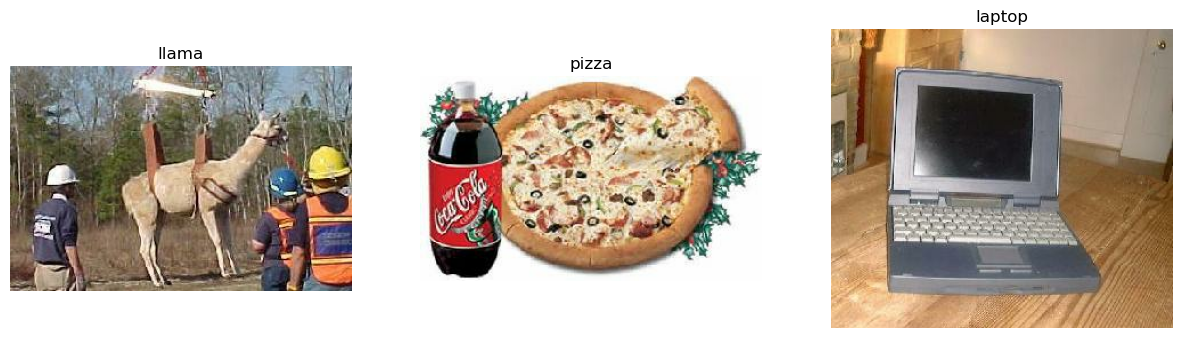

In [21]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

print("Number of classes: ", len(class_names))
for i in range(3):
    image, label = next(iter(data['train'].shuffle(info.splits['train'].num_examples).take(1)))
    axes[i].imshow(image)
    axes[i].set_title(class_names[label.numpy()])
    axes[i].axis('off')
plt.show()

In [45]:
def preprocess(image, label):
    image = tf.image.resize(image, (input_shape[0], input_shape[1]))  
    image = tf.cast(image, tf.float32) / 255.0  
    return image, label

train_resized = data['train'].map(preprocess).batch(32).shuffle(buffer_size=1000)
test_resized = data['test'].map(preprocess).batch(32)

In [32]:
input_shape = (224, 224, 3)
num_classes = len(class_items)

In [46]:
from tensorflow.keras import layers, Model
from keras.activations import relu
from keras import Sequential

def CNN(input_shape, num_classes):
    model = tf.keras.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model
plain_cnn_model = CNN(input_shape, num_classes)

C:\Users\sindr\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


In [34]:
plain_cnn_model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)                   │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 346112)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 128)                 │      44,302,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 102)                 │          13,158 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 44,408,870 (169.41 MB)

 Trainable params: 44,408,870 (169.41 MB)

 Non-trainable params: 0 (0.00 B)

## Frozen ResNet50 (fully frozen)

In [47]:
def FrozenResnet50(input_shape, num_classes):
    base_model = tf.keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = False
    inputs = tf.keras.Input(shape=input_shape)
    x = base_model(inputs, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    model = tf.keras.Model(inputs, outputs)
    return model

frozen_model = FrozenResnet50(input_shape, num_classes)

In [36]:
frozen_model.summary()

Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ resnet50 (Functional)                │ (None, 7, 7, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 102)                 │         208,998 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,796,710 (90.78 MB)

 Trainable params: 208,998 (816.40 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

## Fine-tuned pre-trained ResNet50 

In [48]:
def FineTunedResnet50(input_shape, num_classes):
    base_model = tf.keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = True
    inputs = tf.keras.Input(shape=input_shape)
    x = base_model(inputs, training=True)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(128, activation='relu')(x)  
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    model = tf.keras.Model(inputs, outputs)
    return model

fine_tuned_model = FineTunedResnet50(input_shape, num_classes)

In [38]:
fine_tuned_model.summary()

Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_10 (InputLayer)          │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ resnet50 (Functional)                │ (None, 7, 7, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_2           │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 128)                 │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 102)                 │          13,158 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,863,142 (91.03 MB)

 Trainable params: 23,810,022 (90.83 MB)

 Non-trainable params: 53,120 (207.50 KB)

## Training models

In [53]:
import os
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    print('GPU is available and CUDA is enabled.')
    
os.environ["CUDA_VISIBLE_DEVICES"] = "0" 
os.environ["TF_FORCE_GPU_ALLOW_GROWTH"] = "true"  

In [40]:
# batches = 32
epochs = 5

In [50]:
from keras.losses import SparseCategoricalCrossentropy
plain_cnn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
frozen_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
fine_tuned_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [54]:
plain_cnn_history = plain_cnn_model.fit(train_resized, epochs= epochs, validation_data=test_resized)
frozen_resnet_history = frozen_model.fit(train_resized, epochs= epochs, validation_data=test_resized)

Epoch 1/5
96/96 ━━━━━━━━━━━━━━━━━━━━ 140s 1s/step - accuracy: 0.3689 - loss: 2.8917 - val_accuracy: 0.3203 - val_loss: 3.4725
Epoch 2/5
96/96 ━━━━━━━━━━━━━━━━━━━━ 127s 1s/step - accuracy: 0.8121 - loss: 0.8810 - val_accuracy: 0.3311 - val_loss: 4.8032
Epoch 3/5
96/96 ━━━━━━━━━━━━━━━━━━━━ 136s 1s/step - accuracy: 0.9531 - loss: 0.2291 - val_accuracy: 0.3523 - val_loss: 5.6666
Epoch 4/5
96/96 ━━━━━━━━━━━━━━━━━━━━ 145s 2s/step - accuracy: 0.9856 - loss: 0.0900 - val_accuracy: 0.3423 - val_loss: 5.9099
Epoch 5/5
96/96 ━━━━━━━━━━━━━━━━━━━━ 141s 1s/step - accuracy: 0.9863 - loss: 0.0699 - val_accuracy: 0.3274 - val_loss: 7.2535
Epoch 1/5
96/96 ━━━━━━━━━━━━━━━━━━━━ 468s 5s/step - accuracy: 0.0097 - loss: 4.8270 - val_accuracy: 0.0197 - val_loss: 4.3717
Epoch 2/5
96/96 ━━━━━━━━━━━━━━━━━━━━ 459s 5s/step - accuracy: 0.0549 - loss: 4.4696 - val_accuracy: 0.0606 - val_loss: 4.2503
Epoch 3/5
96/96 ━━━━━━━━━━━━━━━━━━━━ 445s 5s/step - accuracy: 0.0644 - loss: 4.3344 - val_accuracy: 0.1208 - val_loss:

NameError: name 'fine_model' is not defined

In [55]:
fine_tuned_resnet_history = fine_tuned_model.fit(train_resized, epochs= epochs, validation_data=test_resized)

Epoch 1/5
96/96 ━━━━━━━━━━━━━━━━━━━━ 1414s 14s/step - accuracy: 0.1048 - loss: 4.3551 - val_accuracy: 0.0074 - val_loss: 8.7255
Epoch 2/5
96/96 ━━━━━━━━━━━━━━━━━━━━ 980s 10s/step - accuracy: 0.2579 - loss: 3.2410 - val_accuracy: 0.0087 - val_loss: 7.6211
Epoch 3/5
96/96 ━━━━━━━━━━━━━━━━━━━━ 1001s 10s/step - accuracy: 0.4503 - loss: 2.1022 - val_accuracy: 0.0015 - val_loss: 5.6491
Epoch 4/5
96/96 ━━━━━━━━━━━━━━━━━━━━ 1054s 11s/step - accuracy: 0.7504 - loss: 0.9896 - val_accuracy: 0.0016 - val_loss: 7.1663
Epoch 5/5
96/96 ━━━━━━━━━━━━━━━━━━━━ 999s 10s/step - accuracy: 0.8711 - loss: 0.4416 - val_accuracy: 0.0028 - val_loss: 10.9909


In [56]:
def plot_metrics(history, model_name):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_accuracy'], label='val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title(f'{model_name} Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'{model_name} Loss')
    plt.legend()

    plt.show()

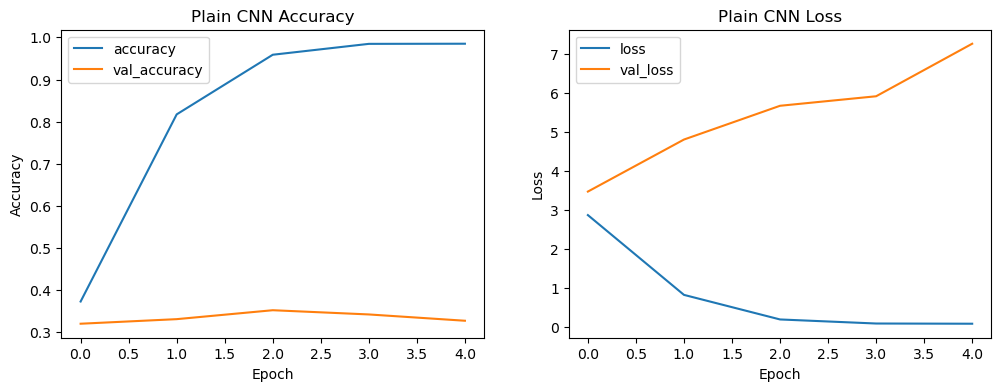

In [57]:
plot_metrics(plain_cnn_history, 'Plain CNN')

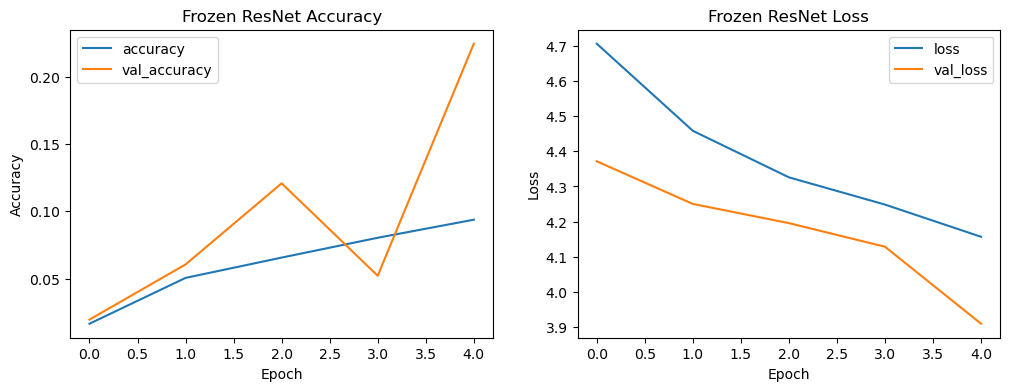

In [58]:
plot_metrics(frozen_resnet_history, 'Frozen ResNet')

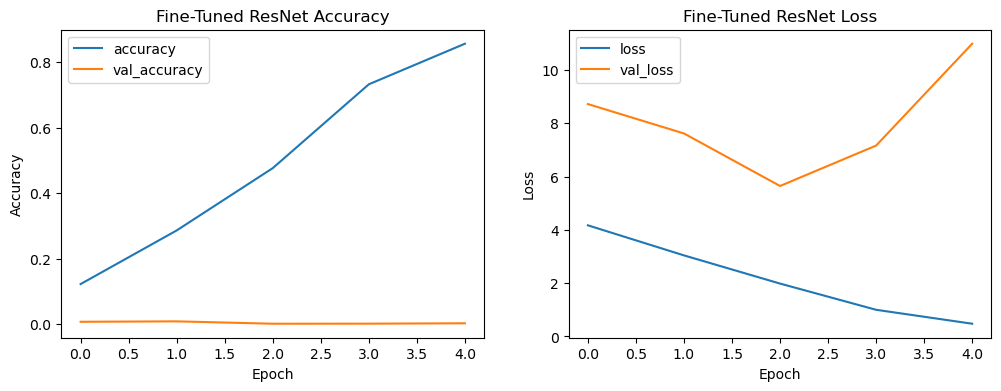

In [59]:
plot_metrics(fine_tuned_resnet_history, 'Fine-Tuned ResNet')

### Attach binaries

In [69]:
plain_cnn_model_path = "C:\\Users\\sindr\\Desktop\\plain_cnn_model.h5"
frozen_resnet_model_path = "C:\\Users\\sindr\\Desktop\\frozen_resnet_model.h5"
fine_tuned_resnet_model_path = "C:\\Users\\sindr\\Desktop\\fine_tuned_resnet_model.h5"

#plain_cnn_model.save(plain_cnn_model_path)
#frozen_model.save(frozen_resnet_model_path)
#fine_tuned_model.save(fine_tuned_resnet_model_path)

## Reports
- 1. `sklearn. metrics.classification_report`
- 2. 101x101 confusion matrices
- 3. Learning curves by hand or TensorBoards learning curves
- 4. ROC Curve plot
- 5. AUC-PRC plot
- 6. The top-1 error rate in %

### Classification Report
- Plain CNN
- Frozen 
- Fine-tuned

In [73]:
def get_true_labels(dataset):
    true_labels = []
    for images, labels in dataset:
        true_labels.extend(labels.numpy())
    return true_labels

plain_cnn_predictions = plain_cnn_model.predict(test_resized)
plain_cnn_true_labels = get_true_labels(test_resized)
plain_cnn_predicted_labels = tf.argmax(plain_cnn_predictions, axis=1)

print("Plain CNN Model Classification Report:")
print(classification_report(plain_cnn_true_labels, plain_cnn_predicted_labels))


191/191 ━━━━━━━━━━━━━━━━━━━━ 41s 215ms/step
Plain CNN Model Classification Report:
              precision    recall  f1-score   support

           0       0.32      0.48      0.38        25
           1       0.94      0.59      0.73       770
           2       0.08      0.25      0.12        12
           3       0.03      0.17      0.05        12
           4       0.00      0.00      0.00       438
           5       0.06      0.12      0.08        17
           6       0.00      0.00      0.00        24
           7       0.00      0.00      0.00        16
           8       0.07      0.33      0.12         3
           9       0.08      0.16      0.11        98
          10       0.28      0.13      0.18        68
          11       0.00      0.00      0.00        13
          12       0.19      0.25      0.22        55
          13       0.09      0.03      0.05        61
          14       0.22      0.10      0.14        20
          15       0.02      0.23      0.03        1

C:\Users\sindr\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\sindr\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\sindr\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [75]:
frozen_predictions = frozen_model.predict(test_resized)
frozen_true_labels = get_true_labels(test_resized)
frozen_predicted_labels = tf.argmax(frozen_predictions, axis=1)

print("Frozen ReaNet Model Classification Report:")
print(classification_report(frozen_true_labels, frozen_predicted_labels))

191/191 ━━━━━━━━━━━━━━━━━━━━ 299s 2s/step
Frozen ReaNet Model Classification Report:
              precision    recall  f1-score   support

           0       0.46      0.44      0.45        25
           1       0.90      0.17      0.29       770
           2       0.00      0.00      0.00        12
           3       0.00      0.00      0.00        12
           4       0.64      0.03      0.06       438
           5       0.00      0.00      0.00        17
           6       0.00      0.00      0.00        24
           7       0.00      0.00      0.00        16
           8       0.00      0.00      0.00         3
           9       0.00      0.00      0.00        98
          10       0.45      0.07      0.13        68
          11       0.00      0.00      0.00        13
          12       0.00      0.00      0.00        55
          13       0.00      0.00      0.00        61
          14       0.00      0.00      0.00        20
          15       0.00      0.00      0.00       

C:\Users\sindr\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\sindr\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\sindr\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [77]:
finetuned_predictions = fine_tuned_model.predict(test_resized)
finetuned_true_labels = get_true_labels(test_resized)
finetuned_predicted_labels = tf.argmax(finetuned_predictions, axis=1)

print("Fine Tuned ReaNet Model Classification Report:")
print(classification_report(finetuned_true_labels, finetuned_predicted_labels))

191/191 ━━━━━━━━━━━━━━━━━━━━ 304s 2s/step
Fine Tuned ReaNet Model Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        25
           1       0.00      0.00      0.00       770
           2       0.00      0.00      0.00        12
           3       0.00      0.00      0.00        12
           4       0.00      0.00      0.00       438
           5       0.25      0.06      0.10        17
           6       0.00      0.00      0.00        24
           7       0.00      0.00      0.00        16
           8       0.00      0.00      0.00         3
           9       0.00      0.00      0.00        98
          10       0.00      0.00      0.00        68
          11       0.00      0.00      0.00        13
          12       0.00      0.00      0.00        55
          13       0.00      0.00      0.00        61
          14       0.00      0.00      0.00        20
          15       0.00      0.00      0.00   

C:\Users\sindr\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\sindr\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\sindr\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Confusion matrixes
- Pain CNN
- Frozen
- Fine-tuned

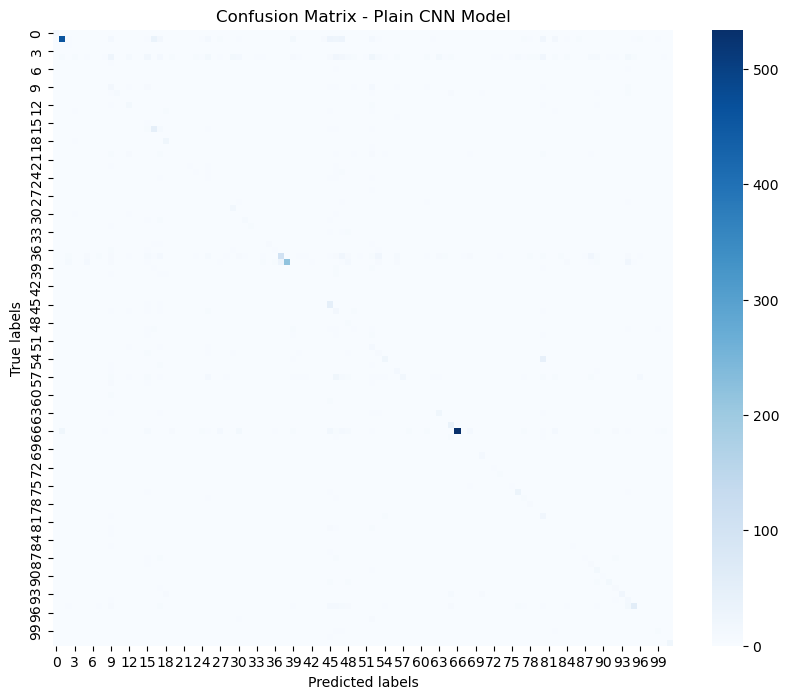

In [85]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(plain_cnn_true_labels, plain_cnn_predicted_labels)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, cmap='Blues')  
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix - Plain CNN Model')
plt.show()

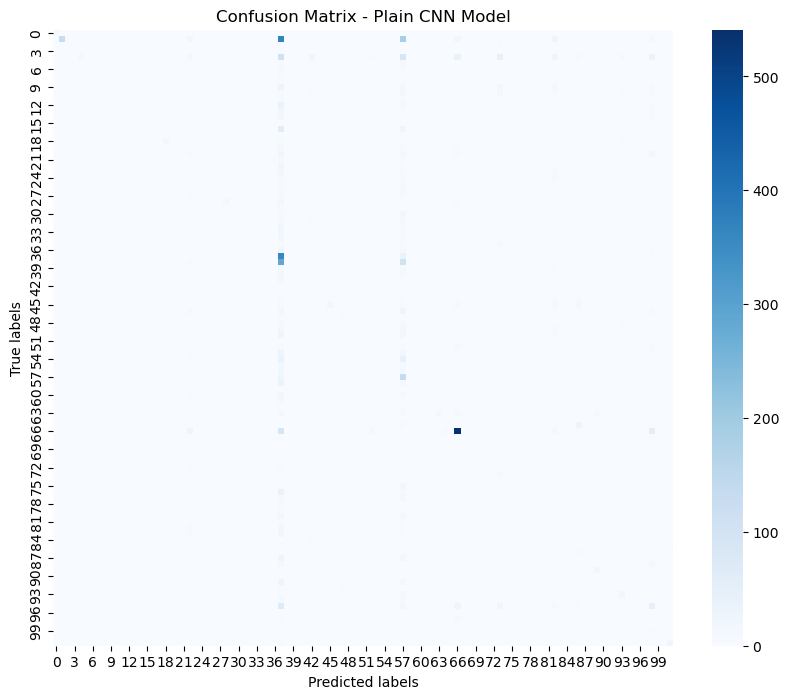

In [87]:
cm_frozen = confusion_matrix(frozen_true_labels, frozen_predicted_labels)

plt.figure(figsize=(10, 8))
sns.heatmap(cm_frozen, cmap='Blues')  
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix - Plain CNN Model')
plt.show()

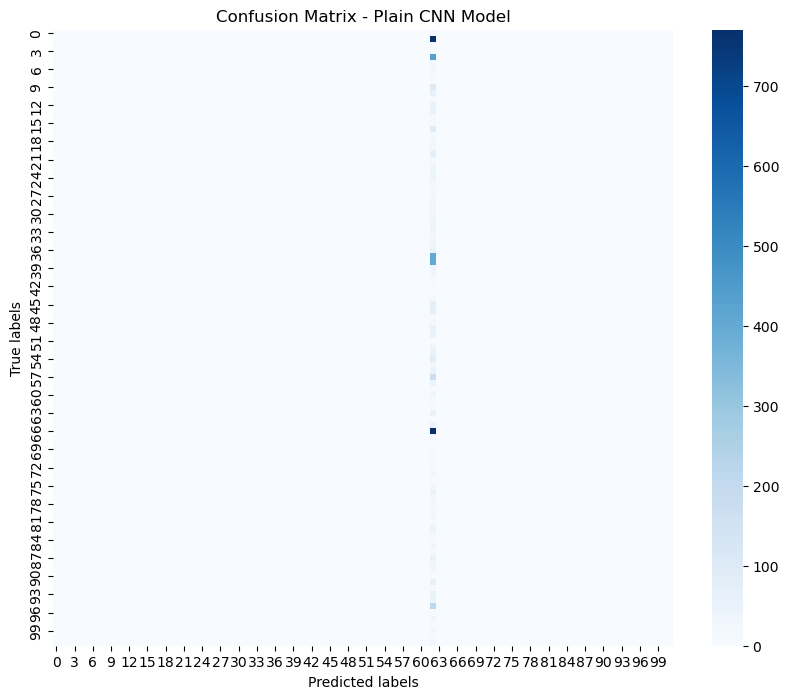

In [88]:
cm_finetuned = confusion_matrix(finetuned_true_labels, finetuned_predicted_labels)

plt.figure(figsize=(10, 8))
sns.heatmap(cm_finetuned, cmap='Blues')  
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix - Plain CNN Model')
plt.show()

## Learning curves
- Plain CNN
- Frozen
- Fine tuned

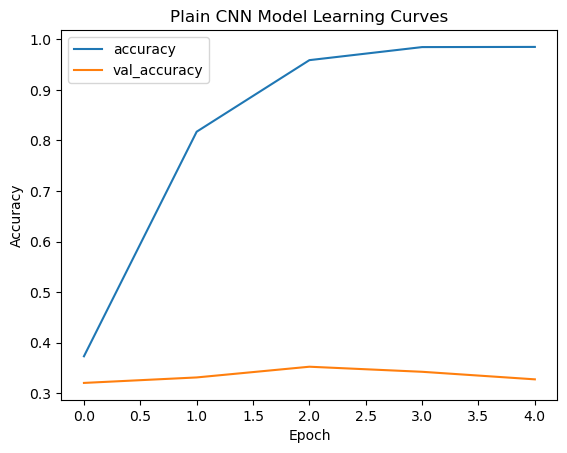

In [89]:
plt.plot(plain_cnn_history.history['accuracy'], label='accuracy')
plt.plot(plain_cnn_history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Plain CNN Model Learning Curves')
plt.legend()
plt.show()

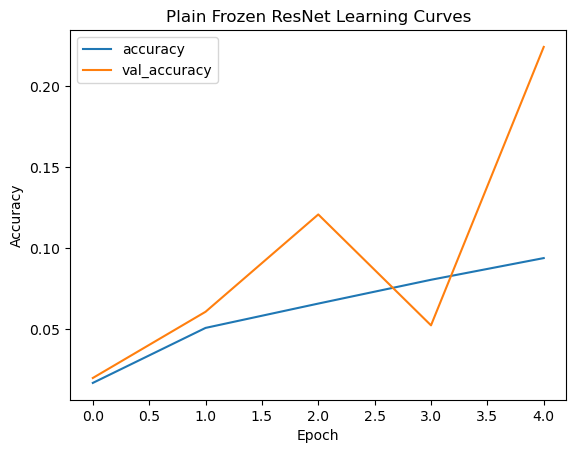

In [90]:
plt.plot(frozen_resnet_history.history['accuracy'], label='accuracy')
plt.plot(frozen_resnet_history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Plain Frozen ResNet Learning Curves')
plt.legend()
plt.show()

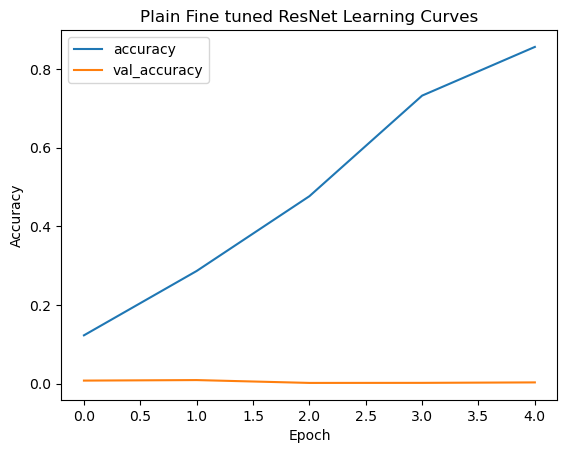

In [91]:
plt.plot(fine_tuned_resnet_history.history['accuracy'], label='accuracy')
plt.plot(fine_tuned_resnet_history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Plain Fine tuned ResNet Learning Curves')
plt.legend()
plt.show()

## POC curves
- Plain CNN
- Frozen
- Fine Tuned

In [99]:
from sklearn.metrics import roc_curve, auc
import matplotlib.lines as mlines

def ROC(model, test_resized, info):
    test_labels = []
    model_probs = []
    for images, labels in test_resized:
        test_labels.extend(labels.numpy())  
        model_probs.extend(model.predict(images)) 
    test_labels = np.array(test_labels)
    test_labels_one_hot = tf.one_hot(test_labels, depth=info.features['label'].num_classes)
    model_probs = np.array(model_probs)
    fig, axs = plt.subplots(10, 11, figsize=(40, 32), sharex=True, sharey=True)
    for i in range(info.features['label'].num_classes):
        ax = axs[i // 11, i % 11]
        line = mlines.Line2D([0, 1], [0, 1], ls="--", color='red')
        transform = ax.transAxes
        line.set_transform(transform)
        fpr, tpr, _ = roc_curve(test_labels_one_hot[:, i], model_probs[:, i])
        auc_score = auc(fpr, tpr)
        ax.add_line(line)
        ax.plot(fpr, tpr, label=f'Class {i}, AUC : {auc_score:.2f}')
        ax.legend(loc='lower right')
        ax.set_title(f'Class {i}')
    plt.tight_layout()
    plt.show()

### Plain CNN

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

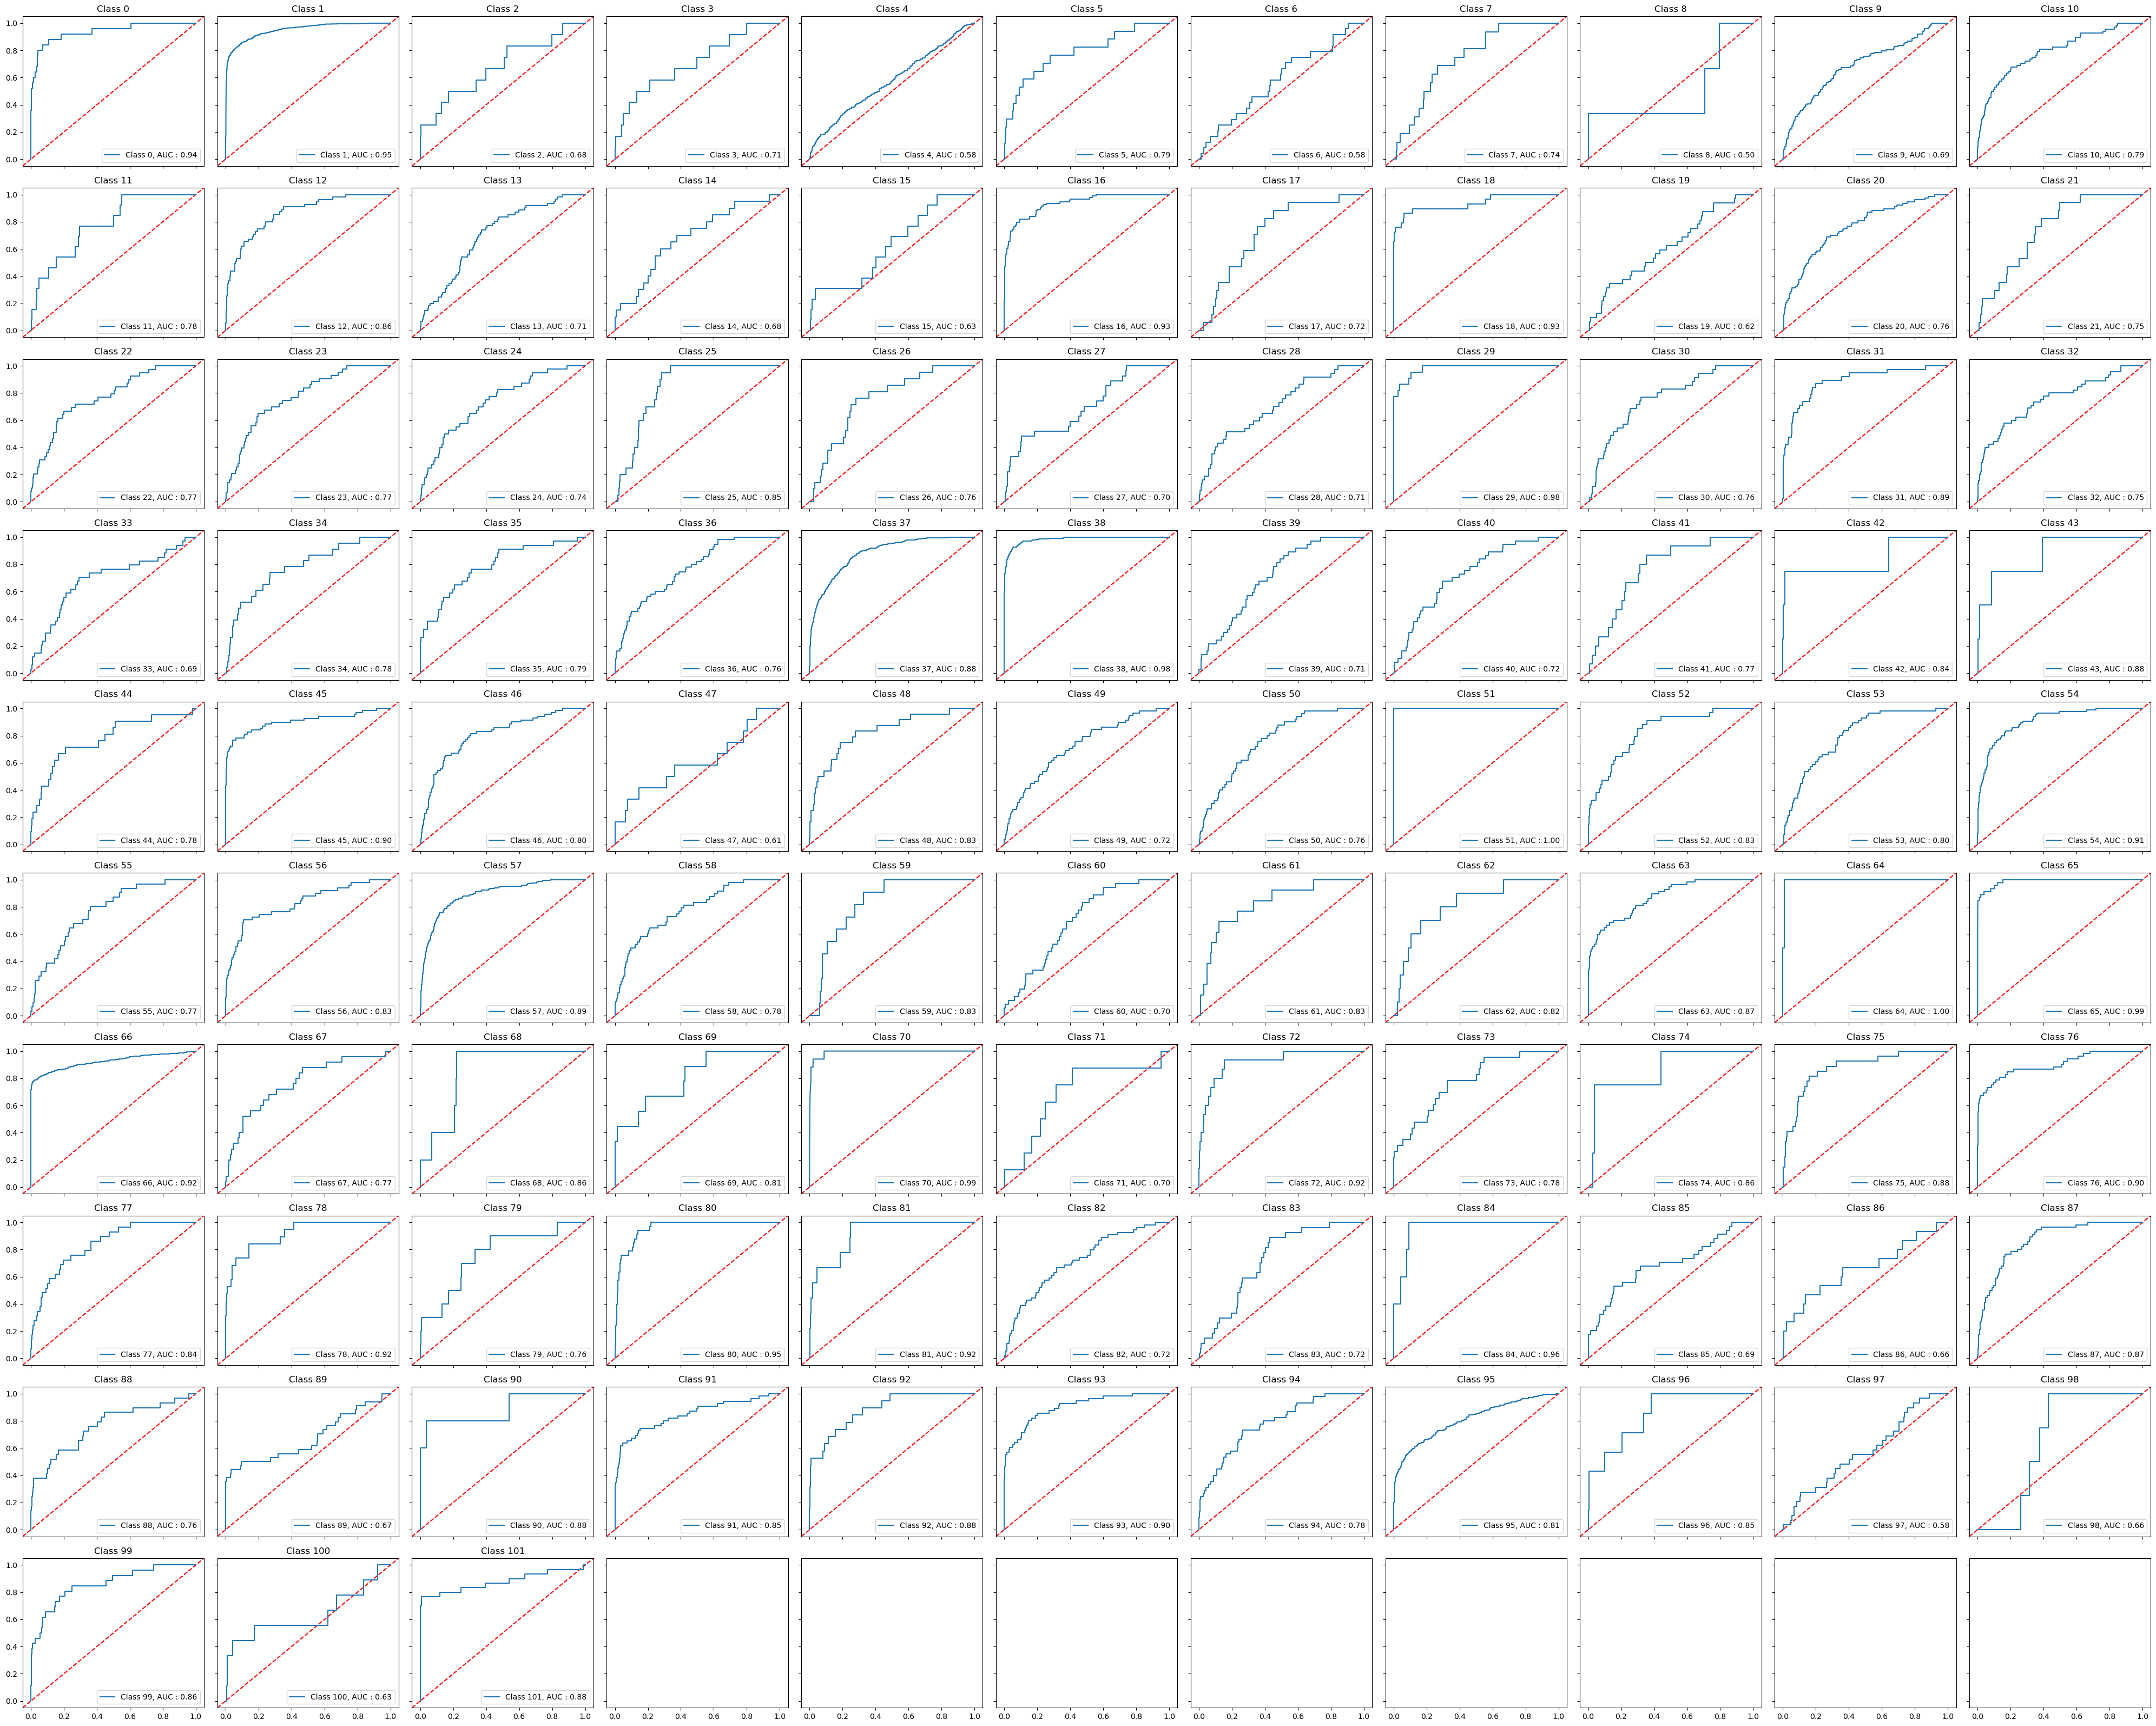

In [100]:
ROC(plain_cnn_model, test_resized, info)

### Frozen ResNet

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 

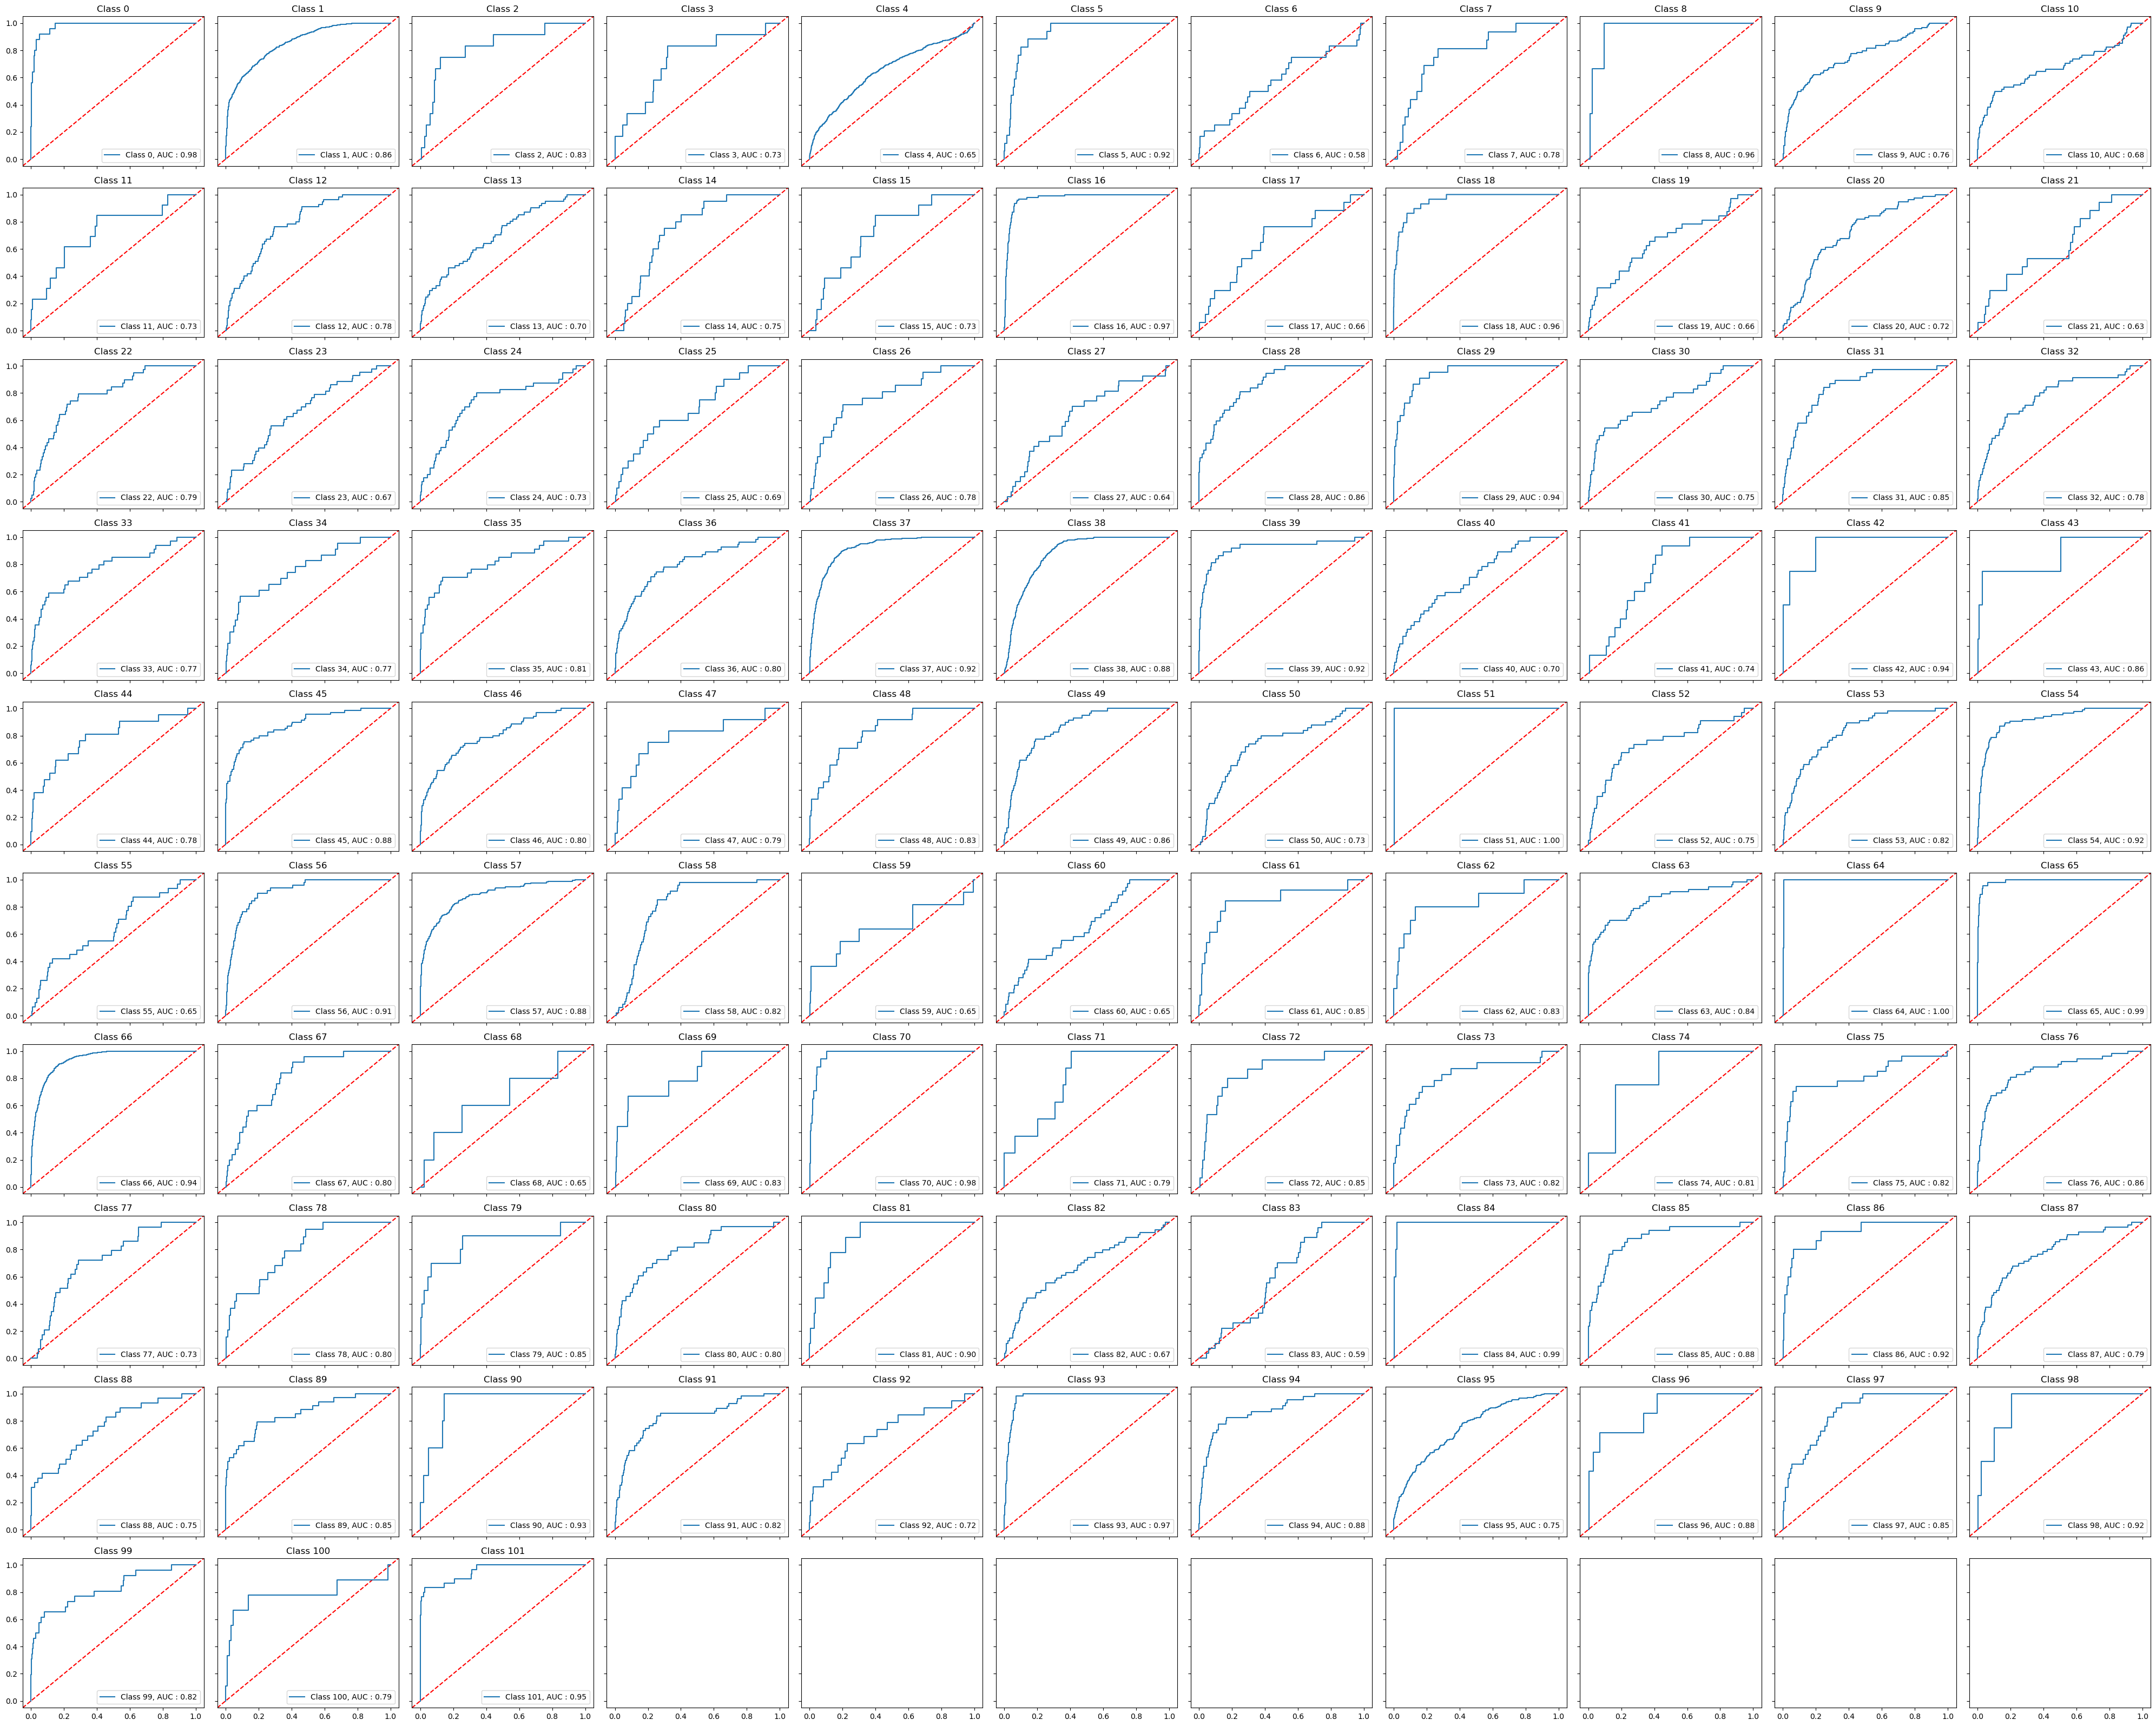

In [101]:
ROC(frozen_model, test_resized, info)

### Fine Tuned ResNet

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 

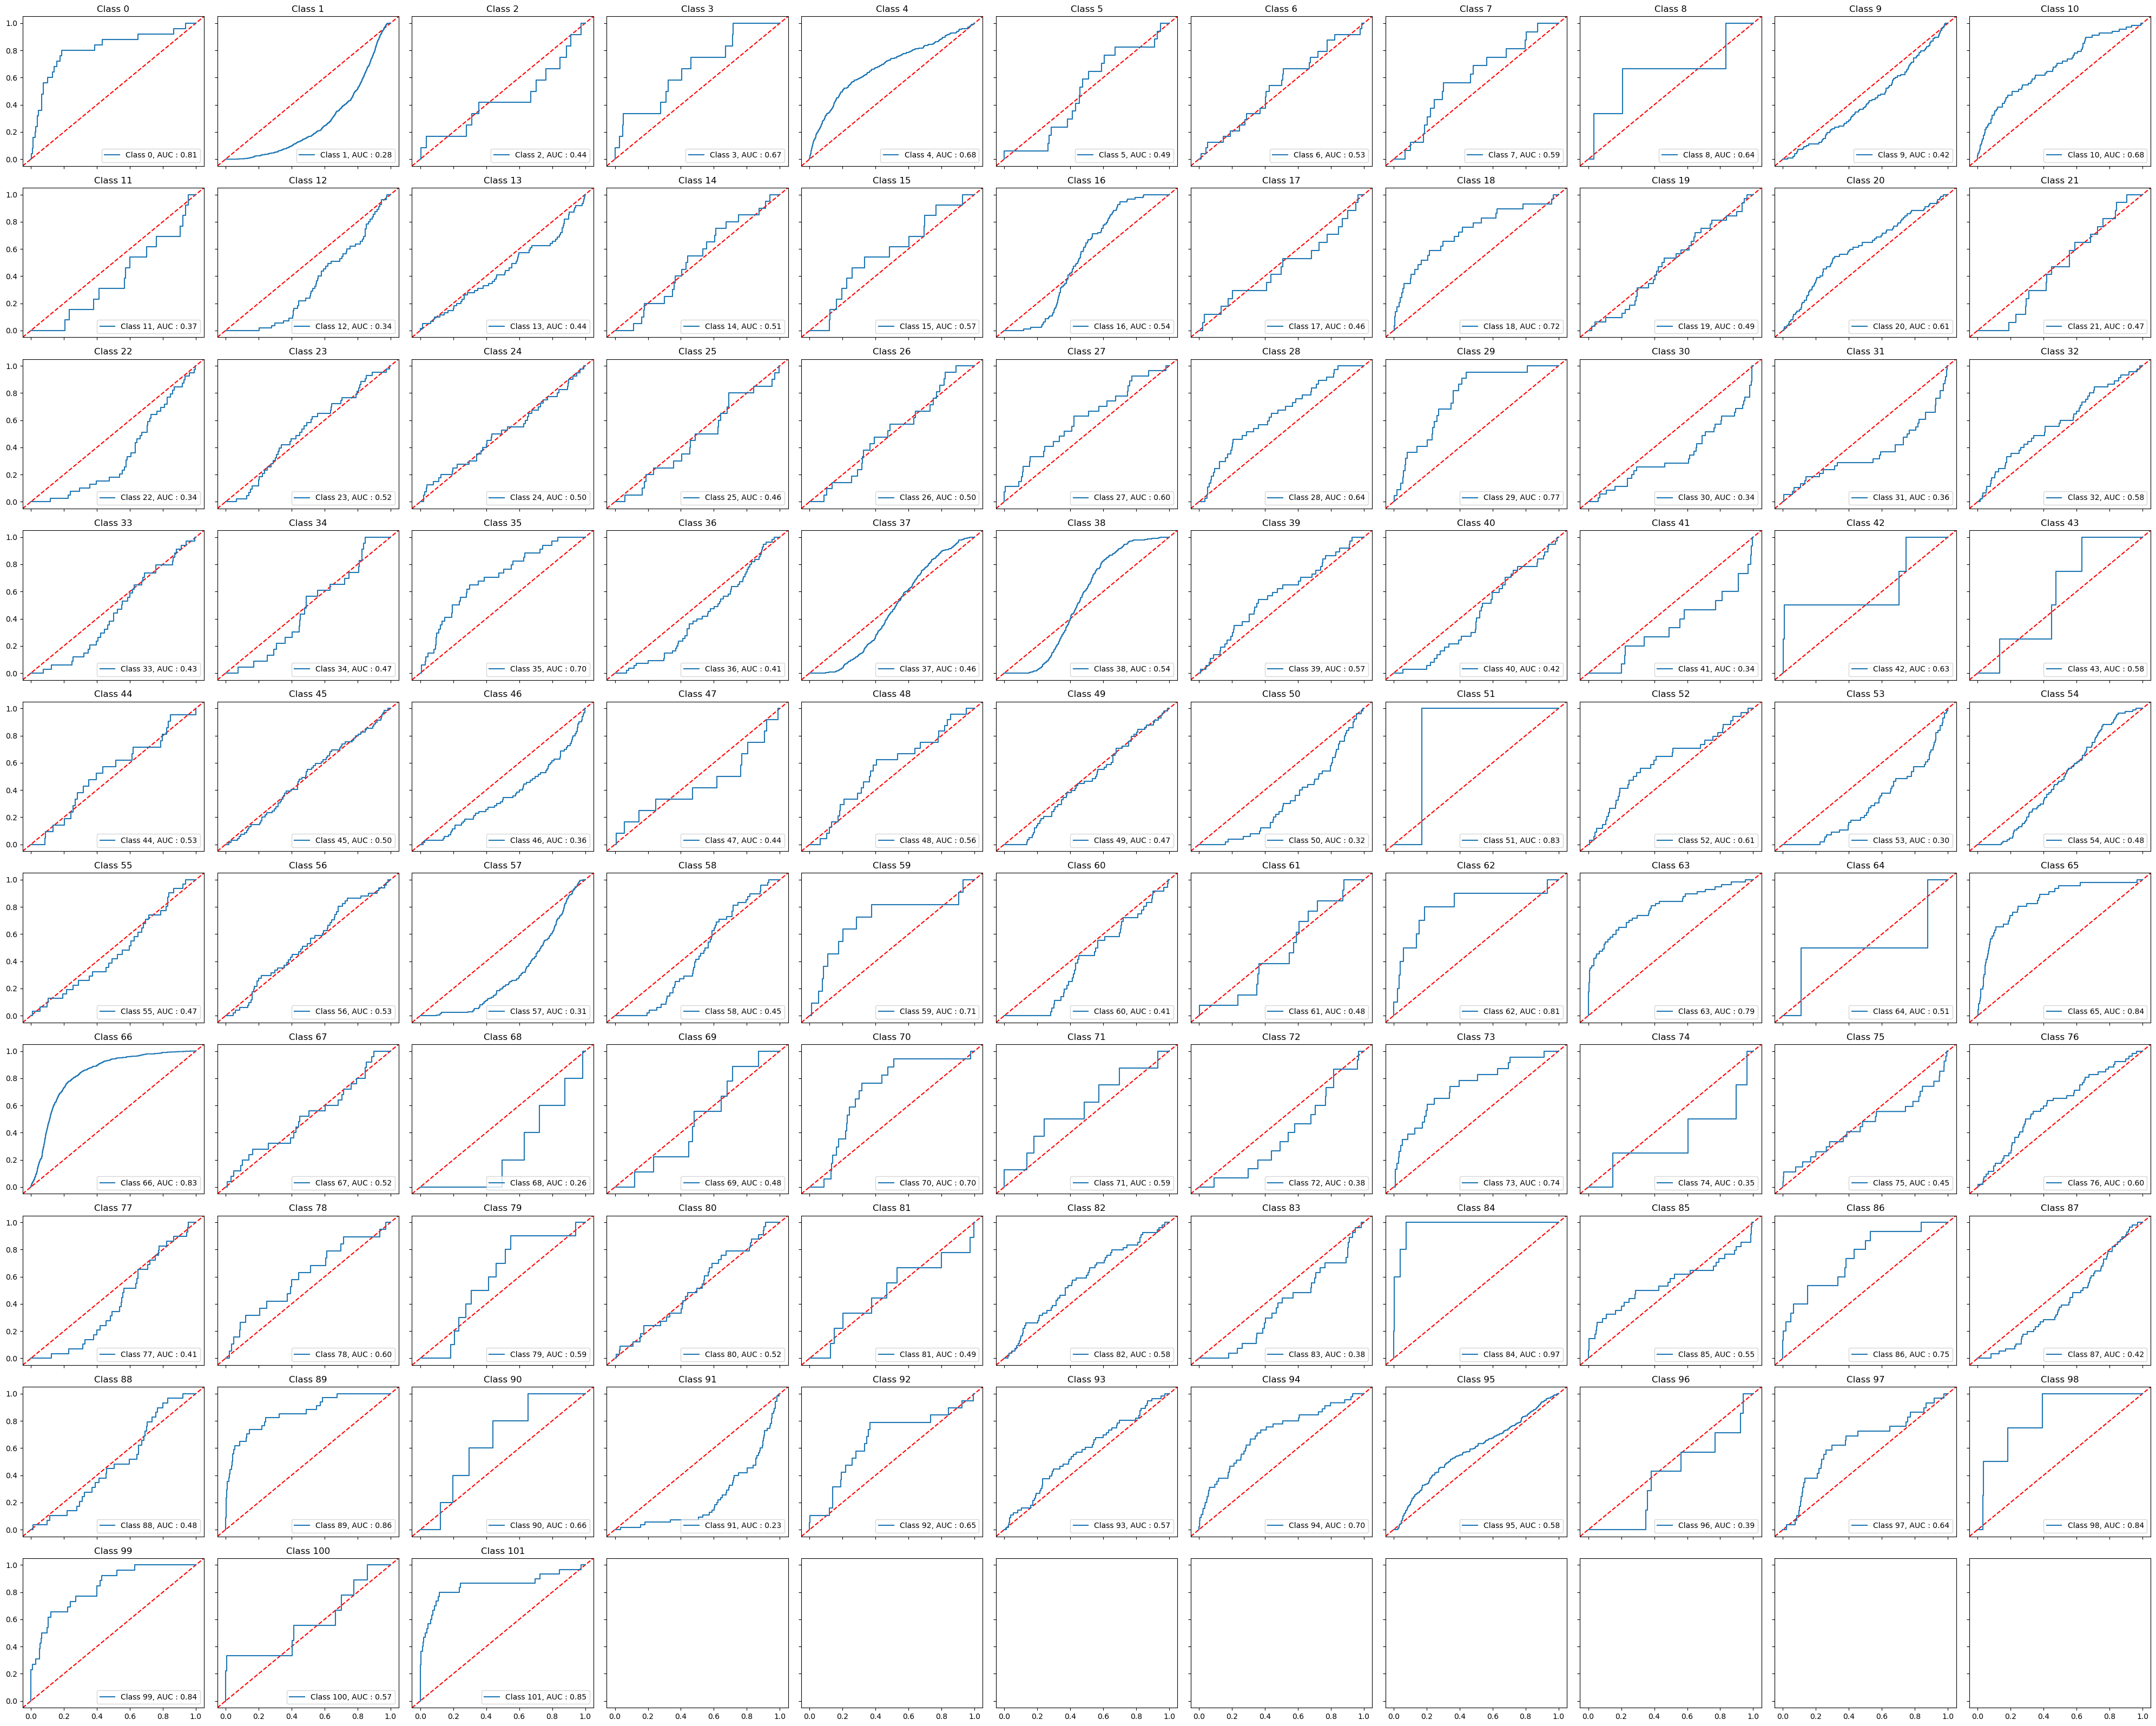

In [103]:
ROC(fine_tuned_model, test_resized, info)

## AUC-PRC
- Plain CNN
- Frozen
- Fine Tuned

In [108]:
def AUC_PRC(model, test_resized, info):
    test_labels = []
    model_probs = []

    for images, labels in test_resized:
        test_labels.extend(labels.numpy())  
        model_probs.extend(model.predict(images))  

    test_labels = np.array(test_labels)
    test_labels_one_hot = tf.one_hot(test_labels, depth=info.features['label'].num_classes)
    model_probs = np.array(model_probs)

    num_classes = info.features['label'].num_classes
    fig, axs = plt.subplots(num_classes // 3, 3, figsize=(15, 5 * (num_classes // 3)))

    for i in range(num_classes):
        precision, recall, _ = precision_recall_curve(test_labels_one_hot[:, i], model_probs[:, i])
        prc_auc = auc(recall, precision)
        
        ax = axs[i // 3, i % 3] if num_classes > 3 else axs[i]
        ax.plot(recall, precision)
        ax.set_xlabel('Recall')
        ax.set_ylabel('Precision')
        ax.set_title(f'Class {i} (AUC = {prc_auc:.2f})')

    plt.tight_layout()
    plt.show()

### Plain CNN

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

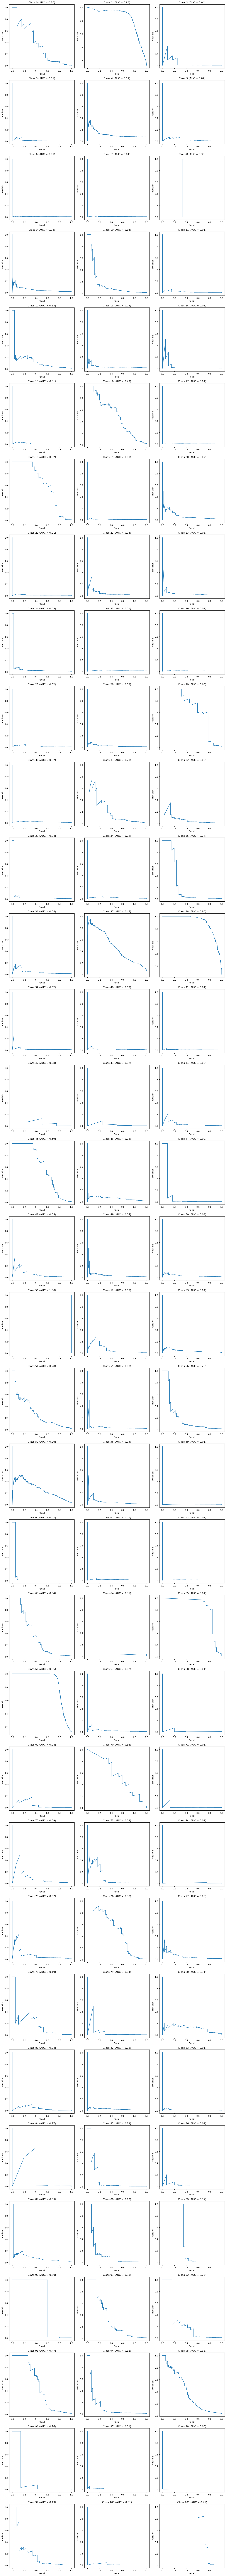

In [109]:
AUC_PRC(plain_cnn_model, test_resized, info)

### Frozen ResNet

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 

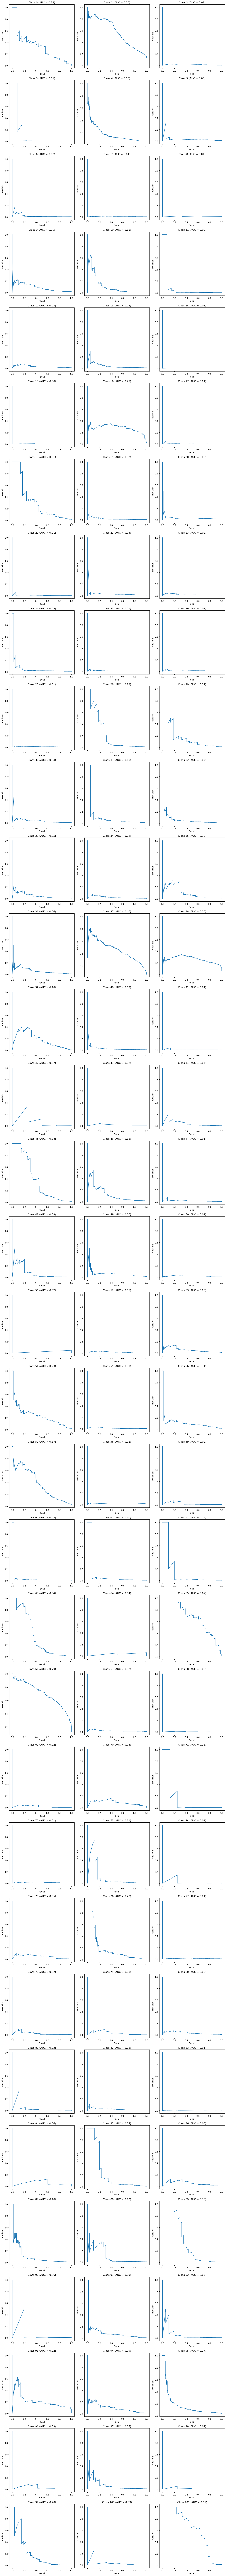

In [110]:
AUC_PRC(frozen_model, test_resized, info)

### Fine tuned ResNet

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 

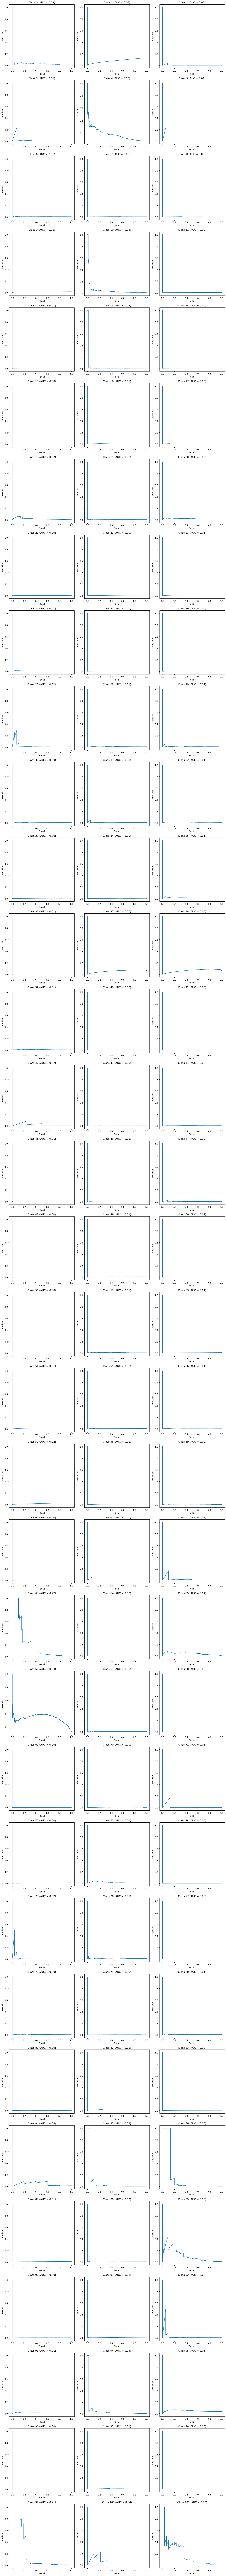

In [111]:
AUC_PRC(fine_tuned_model, test_resized, info)

### The top-1 error rate in %
- Plain CNN
- Frozen
- Fine-tuned

In [117]:
plain_cnn_err = (1 - plain_cnn_model.evaluate(test_resized)[1])*100
print("Top 1 error Plain CNN", plain_cnn_err)

191/191 ━━━━━━━━━━━━━━━━━━━━ 35s 184ms/step - accuracy: 0.3273 - loss: 7.2708
Top 1 error Plain CNN 67.26376414299011


In [118]:
frozen_err = (1 - frozen_model.evaluate(test_resized)[1])*100
print("Top 1 error Frozen ResNet", frozen_err)

191/191 ━━━━━━━━━━━━━━━━━━━━ 289s 2s/step - accuracy: 0.2214 - loss: 3.9151
Top 1 error Frozen ResNet 77.5677889585495


In [119]:
finetuned_err = (1 - fine_tuned_model.evaluate(test_resized)[1])*100
print("Top 1 error Fine Tuned ResNet", finetuned_err)

191/191 ━━━━━━━━━━━━━━━━━━━━ 287s 1s/step - accuracy: 0.0029 - loss: 10.9991
Top 1 error Fine Tuned ResNet 99.72062448505312


### Visualize filters and corresponding feature maps of the first and second Conv2d layers 

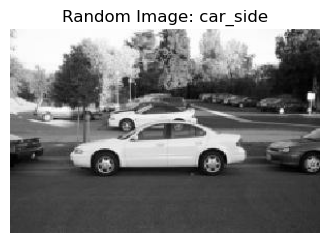

In [133]:
import random

random_index = random.randint(0, len(test) - 1)
random_image, random_label = next(iter(test.skip(random_index).take(1)))

plt.figure(figsize=(4, 4))
plt.imshow(random_image.numpy())
plt.title(f"Random Image: {class_names[random_label.numpy()]}")
plt.axis('off')
plt.show()

In [172]:
def FirstConvo(model, image):
    image = tf.image.resize(image, (224, 224))
    image = tf.expand_dims(image, axis=0)

    activation_model = tf.keras.models.Model(inputs=model.inputs, outputs=model.layers[0].output)
    activations = activation_model.predict(image)

    conv1_weights = model.layers[0].get_weights()[0]
    conv1_feature_maps = activations[0]

    plt.figure(figsize=(16, 8))

    plt.subplot(1, 2, 1)
    plt.title('First Conv2D Layer Weights')
    for i in range(conv1_weights.shape[-1]):
        plt.subplot(4, 8, i+1)
        plt.imshow(conv1_weights[:, :, :, i], cmap='gray')
        plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title('First Conv2D Layer Feature Maps')
    for i in range(conv1_feature_maps.shape[-1]):
        plt.subplot(4, 8, i+1)
        plt.imshow(conv1_feature_maps[:, :, i], cmap='viridis')
        plt.axis('off')

    plt.show()

##  1-st convolutional layer filters&feature maps

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


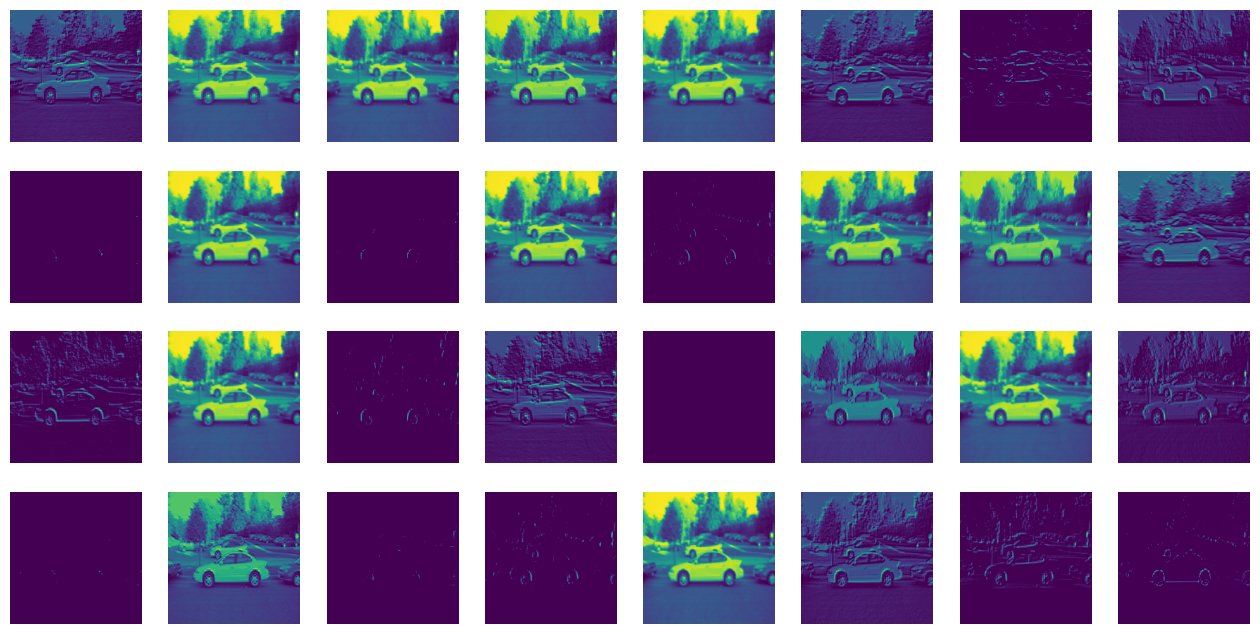

In [164]:
FirstConvo(plain_cnn_model, random_image.numpy())

## 2-nd convolutional layer filters&feature maps

In [185]:
def SecondConvo(model, image):
    image = tf.image.resize(image, (224, 224))
    image = tf.expand_dims(image, axis=0)

    activation_model = tf.keras.models.Model(inputs=model.inputs, outputs=model.layers[2].output)
    activations = activation_model.predict(image)

    conv2_weights = model.layers[2].get_weights()[0]
    conv2_feature_maps = activations[0]

    plt.figure(figsize=(16, 8))

    plt.subplot(1, 2, 1)
    plt.title('Second Conv2D Layer Weights')
    for i in range(conv2_weights.shape[-1]):
        plt.subplot(4, 8, i+1)
        plt.imshow(conv2_weights[:, :, :, i].reshape(conv2_weights.shape[0], conv2_weights.shape[1], -1), cmap='gray')  # Reshape corrected
        plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title('Second Conv2D Layer Feature Maps')
    for i in range(conv2_feature_maps.shape[-1]):
        plt.subplot(4, 8, i+1)
        plt.imshow(conv2_feature_maps[:, :, i], cmap='viridis')
        plt.axis('off')

    plt.show()


In [ ]:
SecondConvo(plain_cnn_model, random_image.numpy())

### Explain the results